Pneumonia is one of the leading respiratory illnesses worldwide, and its timely and accurate diagnosis is essential for effective treatment. Manually reviewing chest X-rays is a critical step in this process, and AI can provide valuable support by helping to expedite the assessment. In your role as a consultant data scientist, you will test the ability of a deep learning model to distinguish pneumonia cases from normal images of lungs in chest X-rays.

By fine-tuning a pre-trained convolutional neural network, specifically the ResNet-18 model, your task is to classify X-ray images into two categories: normal lungs and those affected by pneumonia. You can leverage its already trained weights and get an accurate classifier trained faster and with fewer resources.

## The Data

<img src="x-rays_sample.png" align="center"/>
&nbsp

You have a dataset of chest X-rays that have been preprocessed for use with a ResNet-18 model. You can see a sample of 5 images from each category above. Upon unzipping the `chestxrays.zip` file (code provided below), you will find your dataset inside the `data/chestxrays` folder divided into `test` and `train` folders. 

There are 150 training images and 50 testing images for each category, NORMAL and PNEUMONIA (300 and 100 in total). For your convenience, this data has already been loaded into a `train_loader` and a `test_loader` using the `DataLoader` class from the PyTorch library. 

### LOAD KEY LIBRARIES

In [16]:
# Import required libraries
# -------------------------
# Data loading and plotting
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Train model
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Evaluate model
from torchmetrics import Accuracy, F1Score

# Set random seeds for reproducibility
torch.manual_seed(101010)
np.random.seed(101010)
random.seed(101010)

## STEPS FOR FINE-TUNING A MODEL
1. Load & transform dataset, dataloader
2. Load pretrained model & modify only last layer
4. Train Model
5. Fine-tune Model
6. Evaluate Model

### WHY RESNET-18?
- Useful for building (very) deep neural networks because it overcomes the vanishing gradient problem.
- The vanishing gradient problem is a result of repeated multiplication of gradient during back propagation which results in really small gradients and earlier layer weights are barely or not updated at all.

## 1. LOAD DATA

In [18]:
import os
import zipfile

# Unzip the data folder
if not os.path.exists('data/chestxrays'):
    with zipfile.ZipFile('data/chestxrays.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

### 1.2 Setting Up Data Directory

In [60]:
# check folders within base folder
print(os.listdir('data'))
print(os.listdir('data/chestxrays'))

# define directories
trainimages_dir = os.path.join('data/chestxrays/train')
trainimages_pneu_dir = os.path.join('data/chestxrays/train/PNEUMONIA')
trainimages_norm_dir = os.path.join('data/chestxrays/train/NORMAL')

# check filenames in training directories
trainimages_pneu = os.listdir('data/chestxrays/train/PNEUMONIA')
trainimages_norm = os.listdir('data/chestxrays/train/NORMAL') 
print(f"\nFilenames for Training Pneumonia Images: {trainimages_pneu[:10]}")
print(f"\nFilenames for Training Normal Images: {trainimages_norm[:10]}")

['chestxrays', 'chestxrays.zip']
['test', 'train']

Filenames for Training Pneumonia Images: ['person1028_bacteria_2959.jpeg', 'person1088_bacteria_3028.jpeg', 'person1108_virus_1833.jpeg', 'person1115_virus_1840.jpeg', 'person1150_bacteria_3095.jpeg', 'person1157_virus_1937.jpeg', 'person1159_virus_1944.jpeg', 'person1171_bacteria_3118.jpeg', 'person1175_virus_1981.jpeg', 'person1176_bacteria_3124.jpeg']

Filenames for Training Normal Images: ['IM-0213-0001.jpeg', 'IM-0235-0001.jpeg', 'IM-0245-0001.jpeg', 'IM-0249-0001.jpeg', 'IM-0269-0001.jpeg', 'IM-0273-0001.jpeg', 'IM-0276-0001.jpeg', 'IM-0289-0001.jpeg', 'IM-0295-0001.jpeg', 'IM-0302-0001.jpeg']


### 1.3 Data Visualization

In [22]:
# Data Visualization Packages
import matplotlib as mpimg
from PIL import Image

Notes: 
- PIL - Python Imaging Library, now Pillow

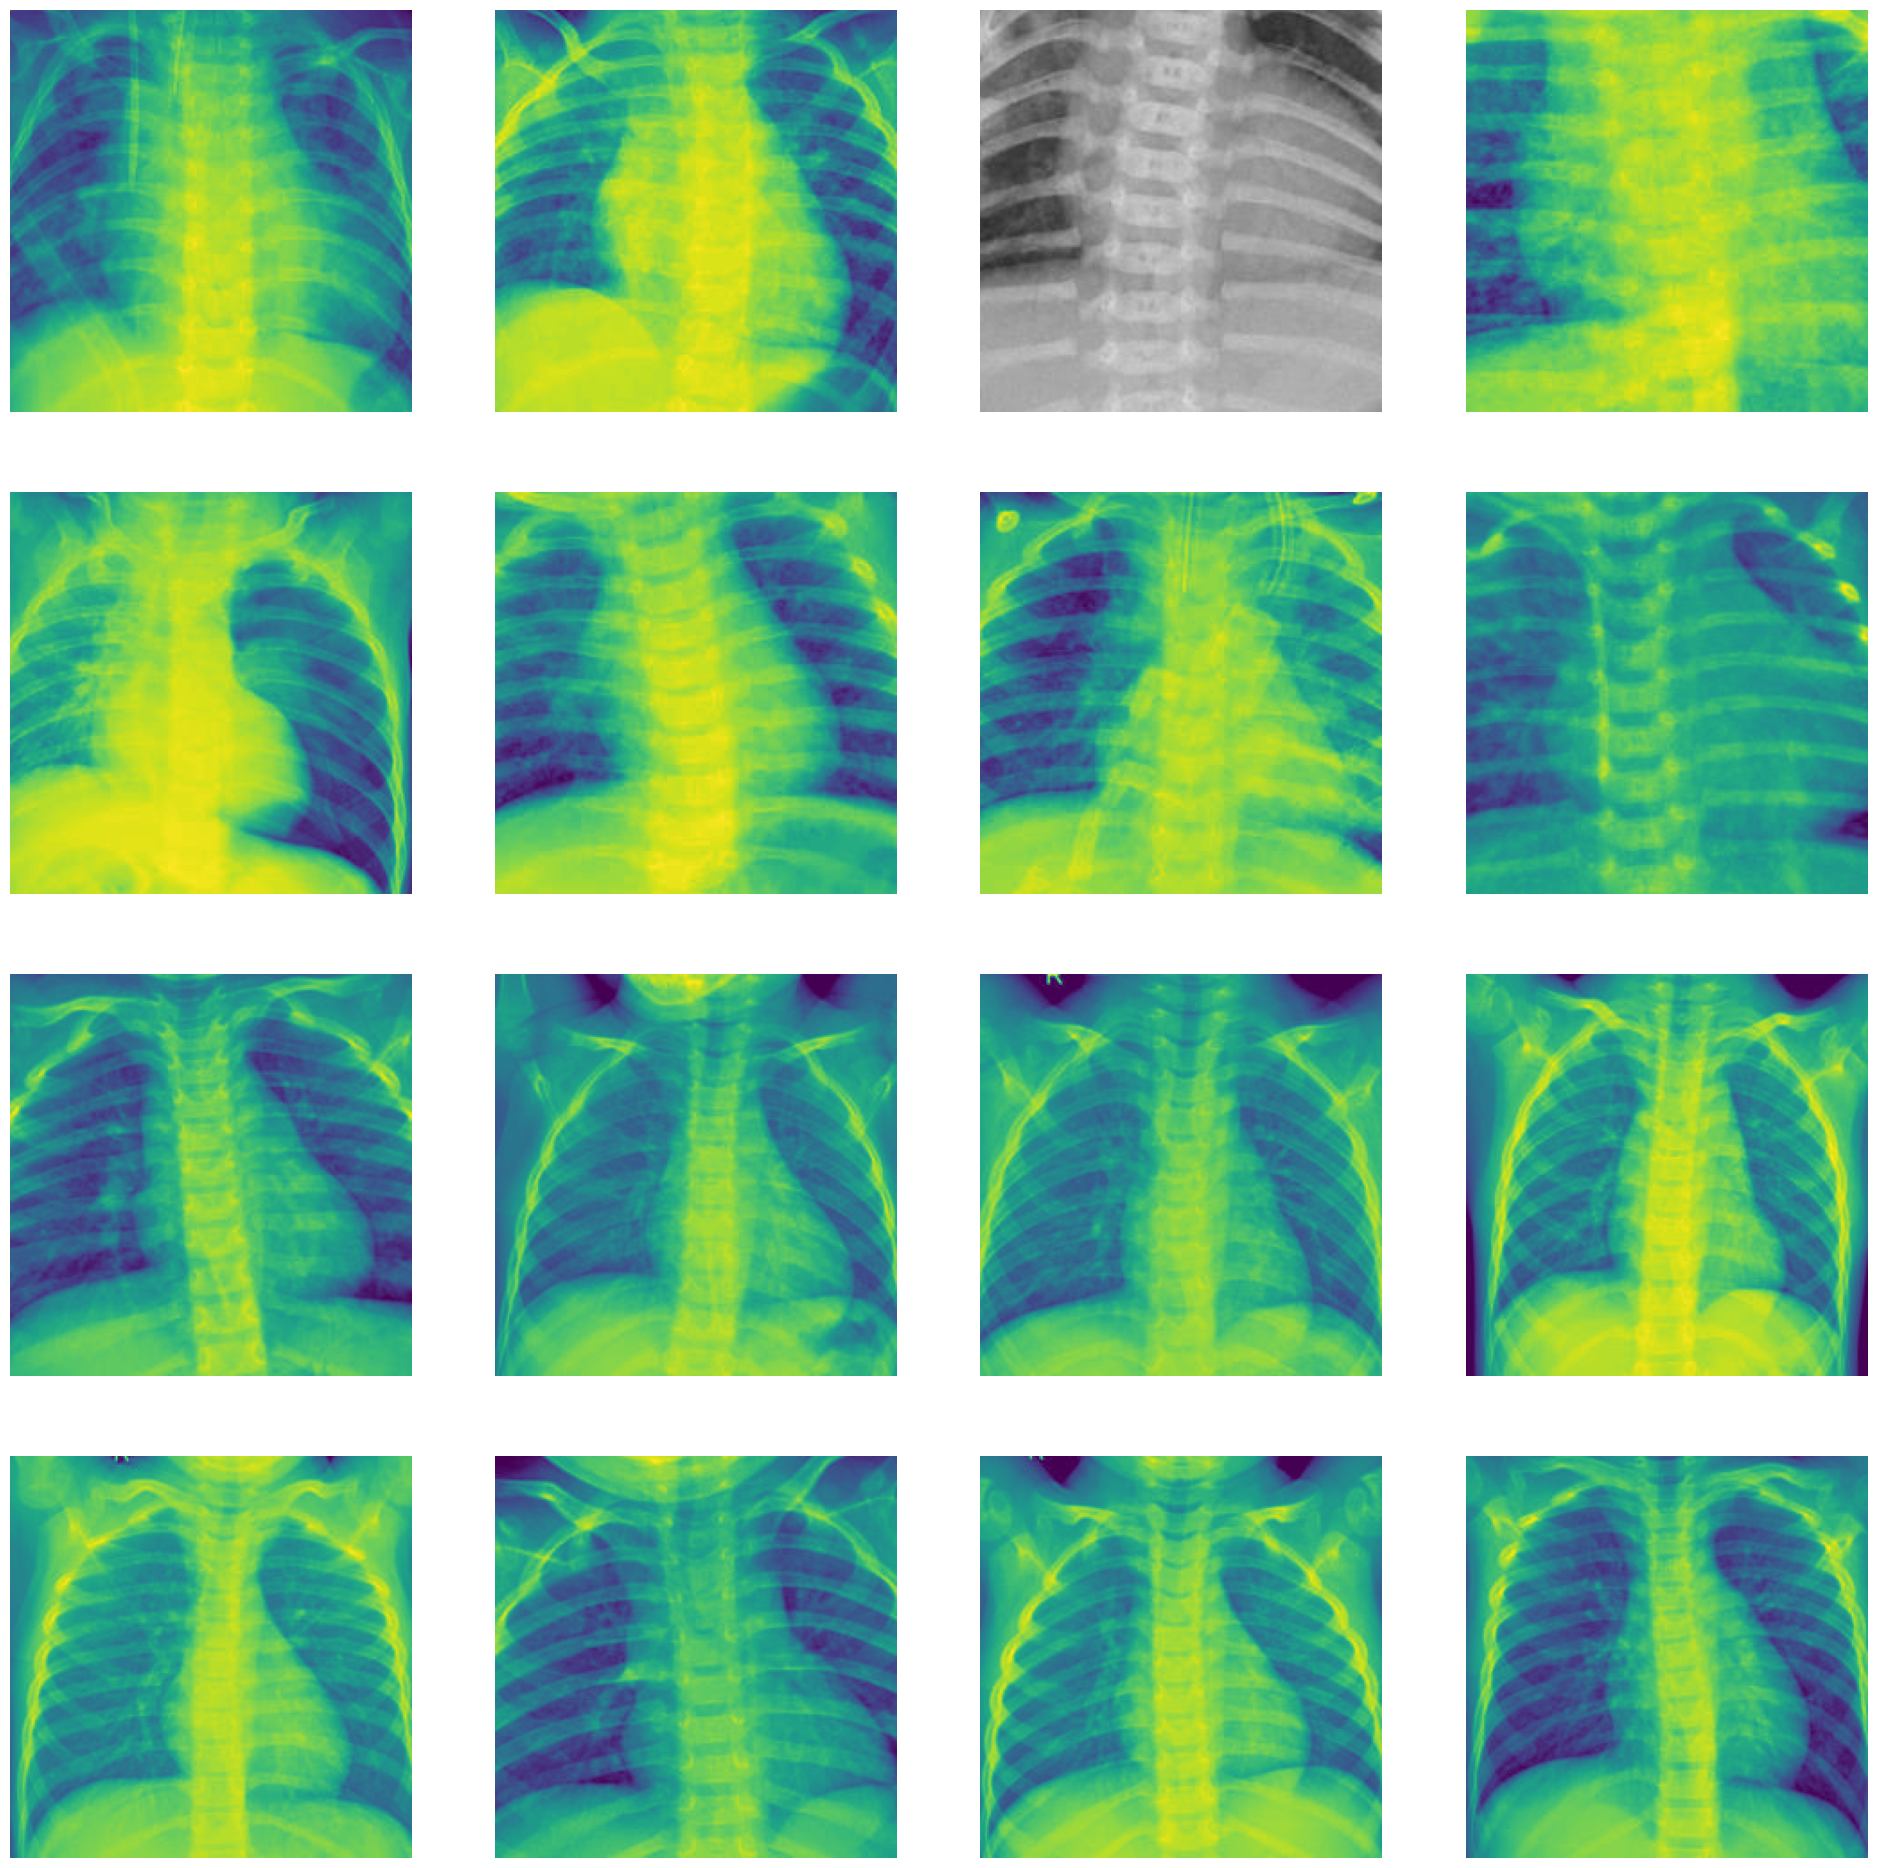

In [24]:
# matplotlib parameters
nrows = 4
ncols = 4

# index to iterate over images
pic_index = 0

# matplotlib 4 x 4 fig set-up
fig = plt.gcf() # get current image
fig.set_size_inches(24, 24)

pic_index += 8
nxt_pneu_pic = [os.path.join(trainimages_pneu_dir, fname)
                for fname in trainimages_pneu[pic_index-8:pic_index]]
nxt_norm_pic = [os.path.join(trainimages_norm_dir, fname)
                for fname in trainimages_norm[pic_index-8:pic_index]]

for i, img_path in enumerate(nxt_pneu_pic+nxt_norm_pic):
  #create subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  imgs = Image.open(img_path)
  plt.imshow(imgs)

### 1.4 Setting Up Dataloader

In [25]:
# Define the transformations to apply to the images for use with ResNet-18
transform_mean = [0.485, 0.456, 0.406]
transform_std =[0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=transform_mean, std=transform_std)])

# Apply the image transforms
train_df = ImageFolder('data/chestxrays/train', transform=transform)
test_df = ImageFolder('data/chestxrays/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_df, batch_size=len(train_df) // 2, shuffle=True)
test_loader = DataLoader(test_df, batch_size=len(test_df))

> Notes:
>- mean and standard deviation calculated for each color channel (R,G,B)

In [28]:
# Check image details
image, label = train_df[0]
print(f"Image size: {image.size()}, Label: {label}]")

for images, labels in train_loader:
    print(images.size(), labels.size())

Image size: torch.Size([3, 224, 224]), Label: 0]
torch.Size([150, 3, 224, 224]) torch.Size([150])
torch.Size([150, 3, 224, 224]) torch.Size([150])


> Notes:
>- torch.Size([150, 3, 224, 224]) torch.Size([150])
>- (150) - number of images; (3) - number of color channels; (224, 224) - dimensions:
   height & width
>- ResNet18 accepts 224 x 224 images 

## 2. LOAD MODEL

In [30]:
# load pretrained model: resnet18 
resnet18 = models.resnet18(weights="IMAGENET1K_V1")
for param in resnet18.parameters():
    param.required_grad = False
        
# modify just the last layer
resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mercy/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:08<00:00, 5.59MB/s]


`Transfer learning:` 
freezing all layers 
-     for param in resnet18.parameters():
          param.requires_grad = False  # Freeze all layers
      resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)  # New classifier
`Fine-tuning:` 
for freezing some layers but not all
-     for name, param in resnet18.named_parameters():
          if "layer4" in name or "fc" in name:  # Unfreeze last layers
              param.requires_grad = True
          else:
              param.requires_grad = False  # Freeze others

In [32]:
# run model on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)  # Sending model to device

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 2.2 Loss Function & Optimizer 
> `Loss Function:` measures prediction's deviation from the ground truth 
  >- most common: cross entropy loss
  >- others include: mse, BCEWithLogitsLoss (Binary cross entropy with logits - combination of sigmoid & binary cross-entropy loss together)

> `Optimizer:` algorithm that updates weights and bias in order to minimize loss
  >- most common: SGD (stochastic gradient descent) - better for fine-tuning 
  >- others include: Adam (adapative moment estimation) - earlier layers, faster convergence, might lead to overfitting

In [34]:
# specify loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    resnet18.fc.parameters(), # only last layer is optimized
    lr=0.0005, # lr should be kept low so that the pre-trained weights don't change easily
    momentum = 0.9
)  

## 3. MODEL TRAINING

In [38]:
num_epochs = 3

for epoch in range(num_epochs):
    resnet18.train()
    training_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device).float()
        
        # reset gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = resnet18(images)
        
        # compute loss + backpropagation
        loss = criterion(outputs.squeeze(), labels) # compare output to ground truth
        loss.backward()
        
        # update weights (& bias?)
        optimizer.step()
        
        training_loss += loss.item()
        

## MODEL EVALUATION

In [40]:
# Set model to evaluation mode
model = resnet18
model.eval()

# Initialize metrics for accuracy and F1 score
accuracy_metric = Accuracy(task="binary")
f1_metric = F1Score(task="binary")

# Create lists store all predictions and labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
  for inputs, labels in test_loader:
    # Forward pass
    outputs = model(inputs)
    preds = torch.sigmoid(outputs).round()  # Round to 0 or 1

    # Extend the lists with predictions and labels
    all_preds.extend(preds.tolist())
    all_labels.extend(labels.unsqueeze(1).tolist())

    # Convert lists back to tensors
    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)

    # Calculate accuracy and F1 score
    test_acc = accuracy_metric(all_preds, all_labels).item()
    test_f1 = f1_metric(all_preds, all_labels).item()

In [46]:
print(test_acc)
print(test_f1)

0.5
0.6666666865348816
